# Loads

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 3.5MB/s 


In [2]:
!nvidia-smi

Mon Jun 15 08:26:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [6]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [7]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [12]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Train flow

In [0]:
import argparse
import pickle
import os
import pandas as pd

from DEwNF.flows import conditional_normalizing_flow_factory3
from DEwNF.utils import split_synthetic
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

import torch.optim as optim
from time import time
from pyro.optim.clipped_adam import ClippedAdam

In [0]:
from tqdm import tqdm

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.04  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None
lr= 8* 1e-4
# Data settings
data_size = 100000

# Training settings
epochs = 2
batch_size = 50000
clipped_adam = 10

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 4
c_net_depth = 10
c_net_h_dim = 18
batchnorm_momentum = 0.1

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 18
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "c_net_depth": c_net_depth,
    "c_net_h_dim": c_net_h_dim,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
# Load data
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

context_dim = len(data_df.columns) - 2

In [0]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim

# Define normalizing flow
normalizing_flow = conditional_normalizing_flow_factory3(flow_depth=flow_depth,
                                                            problem_dim=problem_dim,
                                                            c_net_depth=c_net_depth,
                                                            c_net_h_dim=c_net_h_dim,
                                                            context_dim=context_dim,
                                                            context_n_h_dim=context_n_h_dim,
                                                            context_n_depth=context_n_depth,
                                                            rich_context_dim=rich_context_dim,
                                                            cuda=cuda_exp,
                                                            coupling_dropout=coupling_dropout,
                                                            context_dropout=context_dropout,
                                                            batchnorm_momentum=batchnorm_momentum)

# Setup Optimizer
if clipped_adam is None:
    if l2_reg is None:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg)
else:
    if l2_reg is None:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, clip_norm=clipped_adam)
    else:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg,
                                clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []

for epoch in tqdm(range(1, epochs + 1)):

    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train)

    # save every 10 epoch to log and eval
    if epoch % 10 == 0 or epoch == epochs - 1:
        normalizing_flow.modules.eval()
        train_losses.append(train_epoch_loss / n_train)

        no_noise_epoch_loss = 0
        for k, batch in enumerate(train_dataloader):
            # Add noise reg to two moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            loss = -conditioned_flow_dist.log_prob(x).sum()

            no_noise_epoch_loss += loss.item()
        no_noise_losses.append(no_noise_epoch_loss / n_train)

        test_epoch_loss = 0
        for j, batch in enumerate(test_dataloader):
            # Sample covariates and use them to sample from conditioned two_moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            test_loss = -conditioned_flow_dist.log_prob(x).sum()

            test_epoch_loss += test_loss.item()
        test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}


  0%|          | 0/3000 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
  1%|          | 22/3000 [00:09<23:12,  2.14it/s]

KeyboardInterrupt: ignored

In [0]:
optimizer.param_groups[0]['lr']

0.0008

# Visualize training

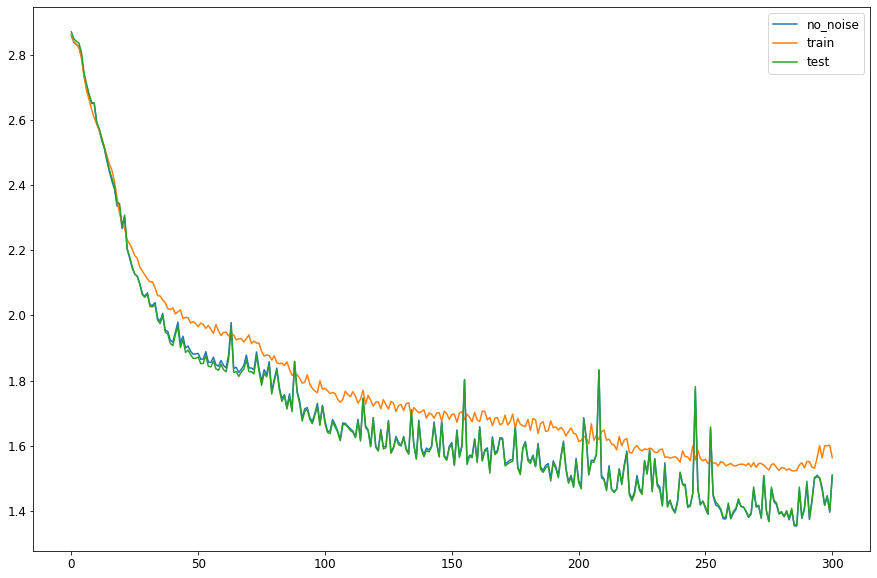

In [0]:
fig, ax = plt.subplots(1, figsize=(15,10))

ax.plot(no_noise_losses)
ax.plot(train_losses)
ax.plot(test_losses)
ax.legend(['no_noise', 'train', 'test'])

# Save model

In [0]:
model_name = f"rotating_two_moons_model_{flow_depth}_layers"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'wb') as f:
    pickle.dump(results_dict, f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
model_name

'rotating_two_moons_model_4_layers'

# Visualize model

In [0]:
flow_depth=48

In [0]:
model_name = f"rotating_two_moons_model_{flow_depth}_layers"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

normalizing_flow = loaded_dict['model']

In [0]:
# Load data
from DEwNF.utils import split_synthetic
batch_size = 500
data_size = 100000
cuda_exp = True
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [32]:

## interactive plot
plt.rcParams.update({'font.size': 20})
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow, obs_scaler, context_scaler):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    scaled_xs = obs_scaler.inverse_transform(x_s)
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    #plt.scatter(scaled_xs[:, 0], scaled_xs[:, 1], c='b', s=1)
    plt.xlim(bounds[0][0],bounds[1][0])
    plt.ylim(bounds[0][1],bounds[1][1])
    test = plt.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    plt.legend(framealpha=0.3, fontsize=15, markerscale=6)
    plt.colorbar(test, shrink=0.6)
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_flow = loaded_dict['model']

In [0]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 10,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 18,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
def create_plot(axs, x, dist, trans_idx, trans_type, obs_scaler):
    bounds = [[-3,-2], [3,2]]
    _, _, _, data = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist, obs_scaler=obs_scaler)  
    x_s = dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    axs.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    #axs.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1, alpha=0.1)
    axs.set_xlim(-3,3)
    axs.set_ylim(-2,2)
    axs.set_title(f'After transformation number {trans_idx} ({trans_type})', fontsize=15)
    axs.legend(framealpha=0.3, fontsize=12, markerscale=6)
    
    colors = axs.imshow(data, cmap='cividis', extent=(3,-3, 2, -2))
    return colors
    

In [0]:
def rename_trans(name):
    if name == "ConditionedAffineCoupling2()":
        return "Conditioned Affine Coupling"
    if name == "Permute()":
        return "Permute"
    if name == "BatchNorm()":
        return "Batchnorm"

def model_tester4(theta, flow):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _= cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots(((n_trans) // 2) +1 , 2,  figsize=(25,n_trans*5),gridspec_kw = {'wspace':0, 'hspace':0})

    colors = create_plot(axs[0, 0], x, cond_dist.base_dist.to_event(1), 0, 'Base distribution', obs_scaler)
    plt.colorbar(colors, ax=axs[0,0], shrink=0.8)
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = rename_trans(cond_dist.transforms[i].__str__())
        colors = create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, temp_dist, i+1, trans_type, obs_scaler)
        plt.colorbar(colors, ax=axs[(i+1) // 2, (i+1) % 2 ],shrink=0.8)
    if n_trans % 2 == 0:
        fig.delaxes(axs[n_trans//2, 1])

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               trans_1=(-4.,4.),
                               trans_2=(-4.,4.),
                               flow_dist=fixed(loaded_flow.dist))
interactive_plot


In [0]:
model_tester4(0.,0.,0.,0.,loaded_flow.dist)

In [0]:
model_tester4(1.,1.,2.,-2.,loaded_flow.dist)

# Test with newer model

In [0]:
file_name = 'old_flows/c_nf_two_moon_proper_covariate_training.pickle'
file_path = os.path.join(trained_flows_folder, file_name)
with open(file_path, 'rb') as f:

    loaded_flow = pickle.load(f)

In [0]:
def create_overlay2(shape, bounds, flow_dist):
    cm = matplotlib.cm.get_cmap('cividis')
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1)
    data = flow_dist.log_prob(points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay

def model_tester4(theta, flow):
    theta = torch.tensor([theta])

    context = torch.tensor((theta)).unsqueeze(0)
    cond_dist = flow.dist.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay2(shape = (200,200), bounds=bounds, flow_dist = cond_dist)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5)
    plt.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1)
    plt.xlim(-6,6)
    plt.ylim(-5,5)
    plt.imshow(overlay, extent=(6,-6, 5, -5))
    plt.show()

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(loaded_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

# TEST

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.00  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None

# Data settings
data_size = 100000

# Training settings
epochs = 1000
batch_size = 30000
clipped_adam = 10

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 10
c_net_depth = 4
c_net_h_dim = 18
batchnorm_momentum = 0.1

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 10
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "c_net_depth": c_net_depth,
    "c_net_h_dim": c_net_h_dim,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim

# Define normalizing flow
normalizing_flow = conditional_normalizing_flow_factory3(flow_depth=flow_depth,
                                                            problem_dim=problem_dim,
                                                            c_net_depth=c_net_depth,
                                                            c_net_h_dim=c_net_h_dim,
                                                            context_dim=context_dim,
                                                            context_n_h_dim=context_n_h_dim,
                                                            context_n_depth=context_n_depth,
                                                            rich_context_dim=rich_context_dim,
                                                            cuda=cuda_exp,
                                                            coupling_dropout=coupling_dropout,
                                                            context_dropout=context_dropout,
                                                            batchnorm_momentum=batchnorm_momentum)

# Setup Optimizer

optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=1e-4, clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []

normalizing_flow.modules.train()
for k in tqdm(range(1000)):
    
    # Sample covariates and use them to sample from conditioned two_moons
    time1 = time()
    x, y, theta = cond_two_moons.joint_sample(128)
    
    # Condition the flow on the sampled covariate and calulate -log_prob = loss
    time2 = time()
    conditioned_flow_dist = normalizing_flow.condition(theta.cuda())
    loss = -conditioned_flow_dist.log_prob(x.cuda()).sum()

    # Calculate gradients and take an optimizer step
    time3 = time()
    normalizing_flow.modules.zero_grad()
    loss.backward()
    optimizer.step()

    # If plotting iteration plot
    if k % 500 == 0:
        time4 = time()
        normalizing_flow.modules.eval()
        clear_output(wait=True)
        print(f"{k}: {loss.item()}")
        # plot_samples(conditioned_flow_dist,x) todo work on a plot # Plot does not work very well with the joint sampling scheme. It's a TODO to make a better plotting.
        time5 = time()
        print(
            f"Time spent \n Sampling: {time2 - time1} \n Calculating loss: {time3 - time2} \n Gradient step: {time4 - time3} \n Plot: {time5 - time4}"
        )
        normalizing_flow.modules.train()



 50%|█████     | 502/1000 [00:42<00:43, 11.46it/s]

500: 273.3257141113281
Time spent 
 Sampling: 0.015078544616699219 
 Calculating loss: 0.022990942001342773 
 Gradient step: 0.05276966094970703 
 Plot: 0.001932382583618164



100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


In [0]:
## interactive plot

cond_two_moons = RotatingTwoMoonsConditionalSampler()

def model_tester3(theta, flow):
    theta = torch.tensor([theta])

    context = torch.tensor((theta)).unsqueeze(0).cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay(shape = (200,200), bounds=bounds, flow_dist = cond_dist)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5)
    plt.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1)
    plt.xlim(-6,6)
    plt.ylim(-5,5)
    plt.imshow(overlay, extent=(6,-6, 5, -5))
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train)

    # save every 10 epoch to log and eval
    if epoch % 10 == 0 or epoch == epochs - 1:
        normalizing_flow.modules.eval()
        train_losses.append(train_epoch_loss / n_train)

        no_noise_epoch_loss = 0
        for k, batch in enumerate(train_dataloader):
            # Add noise reg to two moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            loss = -conditioned_flow_dist.log_prob(x).sum()

            no_noise_epoch_loss += loss.item()
        no_noise_losses.append(no_noise_epoch_loss / n_train)

        test_epoch_loss = 0
        for j, batch in enumerate(test_dataloader):
            # Sample covariates and use them to sample from conditioned two_moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            test_loss = -conditioned_flow_dist.log_prob(x).sum()

            test_epoch_loss += test_loss.item()
        test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
bas
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}
